In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset

from esn_lib.esn import *
from esn_lib.re_hubesn import *
from esn_tasks.mackey_glass.mackey import *

In [2]:
mode = 'hub'

EXPTPATH = f'../results/mackey/n_train_{mode}'
PLTPATH = f'../plots/mackey'
params = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 500,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': mode,
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

## Iterate through diffferent training length

In [4]:
n_trains = np.arange(100, 2700, 100, dtype=int)
n_test = 2000
repeat = 30
for nt in n_trains:
    task_pm = {
        'n_train': nt,
        'n_test': n_test,
    }
    task = MackeyGlass(**task_pm)
    hubesn_rmse, hubesn_pred = [], []
    esn_rmse, esn_pred = [], []
    for i in range(repeat):
        esn = HubESN(**params)
        esn.fit(task.X_train, task.y_train)
        y_pred, _ = esn.predict(task.X_test)
        hubesn_pred.append(y_pred)
        hubesn_rmse.append(task.rmse(y_pred, task.y_test))

        esn = ESN(**params)
        esn.fit(task.X_train, task.y_train)
        y_pred, _ = esn.predict(task.X_test)
        esn_pred.append(y_pred)
        esn_rmse.append(task.rmse(y_pred, task.y_test))
        
    np.save(f'{EXPTPATH}/hubesn_rmse_{nt}.npy', np.array(hubesn_rmse))
    np.save(f'{EXPTPATH}/hubesn_pred_{nt}.npy', np.array(hubesn_pred))
    np.save(f'{EXPTPATH}/esn_rmse_{nt}.npy', np.array(esn_rmse))
    np.save(f'{EXPTPATH}/esn_pred_{nt}.npy', np.array(esn_pred))
    np.save(f'{EXPTPATH}/y_test_{nt}.npy', task.y_test)

## Plot

In [79]:
def load_n_trains_results(mode, task, n_trains, std_mode='std'):
    path = f'../results/{task}/n_train_{mode}'
    esn_mean, esn_std = [], []
    hubesn_mean, hubesn_std = [], []
    for nt in n_trains:
        hubesn_rmse = np.load(f'{path}/hubesn_rmse_{nt}.npy')
        esn_rmse = np.load(f'{path}/esn_rmse_{nt}.npy')
        hubesn_mean.append(np.nanmean(hubesn_rmse))
        esn_mean.append(np.nanmean(esn_rmse))

        if std_mode == 'std':
            hubesn_std.append(np.nanstd(hubesn_rmse))
            esn_std.append(np.nanstd(esn_rmse))
        elif std_mode == 'q':
            # use the 25th and 75th percentile as error bar
            hubesn_q1, hubesn_q3 = np.percentile(hubesn_rmse, [25, 75])
            esn_q1, esn_q3 = np.percentile(esn_rmse, [25, 75])
            hubesn_std.append([hubesn_q1, hubesn_q3])
            esn_std.append([esn_q1, esn_q3])
    esn_mean, esn_std = np.array(esn_mean), np.array(esn_std)
    hubesn_mean, hubesn_std = np.array(hubesn_mean), np.array(hubesn_std)

    return esn_mean, esn_std, hubesn_mean, hubesn_std

def get_plot_range(cur_task):
    if cur_task == 'mackey':
        n_trains = np.arange(600, 2700, 100)
    elif cur_task == 'narma10':
        n_trains = np.arange(600, 2200, 100)
    elif cur_task == 'lorenz':
        n_trains = np.arange(200, 300, 20)
    return n_trains

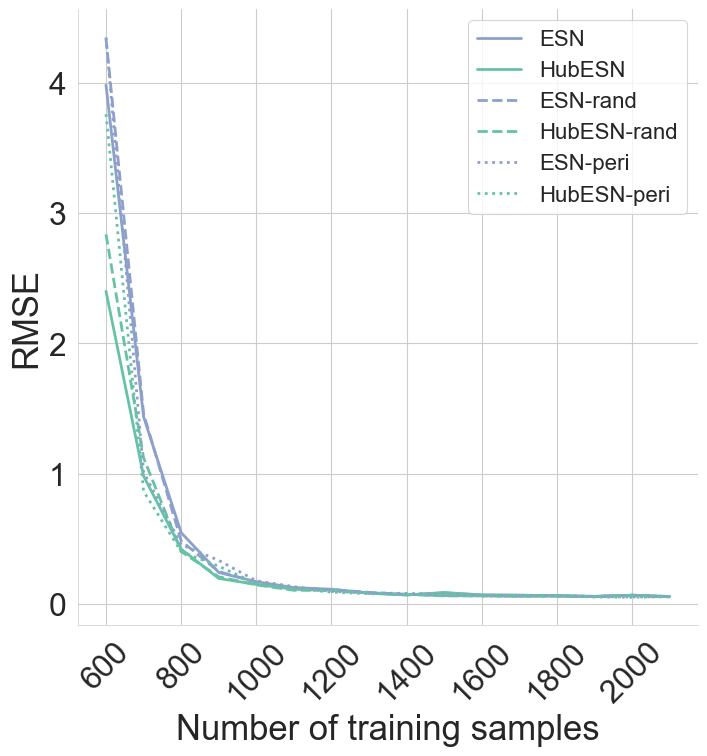

In [80]:
cur_task = 'narma10'
n_trains = get_plot_range(cur_task)
esn_mean, esn_std, hubesn_mean, hubesn_std = load_n_trains_results('hub', cur_task, n_trains, std_mode='std')
esn_rand_mean, esn_rand_std, hubesn_rand_mean, hubesn_rand_std = load_n_trains_results('rand', cur_task, n_trains, std_mode='std')
esn_peri_mean, esn_peri_std, hubesn_peri_mean, hubesn_peri_std = load_n_trains_results('peri', cur_task, n_trains, std_mode='std')

PLTPATH = f'../plots/mackey'

# plot settings
font_scale = 2.6
plot_error = False
font_size = 16
capsize = 3
lw = 2
esn_color = 2
hubesn_color = 0
lw_inset = 1.5
show_closeup = False

# begin plotting
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=font_scale)
sns.set_color_codes("bright")
colors = sns.color_palette("Set2")
fig, ax = plt.subplots(figsize=(8, 8))
if plot_error:
    # ax.errorbar(n_trains, esn_mean, yerr=[esn_q1, esn_q3], color=colors[esn_color], capsize=capsize, lw=lw)
    # ax.errorbar(n_trains, hubesn_mean, yerr=[hubesn_q1, hubesn_q3], color=colors[hubesn_color], capsize=capsize, lw=lw)
    ax.errorbar(n_trains, esn_mean, yerr=esn_std.T, color=colors[esn_color], capsize=capsize, lw=lw)
    ax.errorbar(n_trains, hubesn_mean, yerr=hubesn_std.T, color=colors[hubesn_color], capsize=capsize, lw=lw)
    ax.errorbar(n_trains, esn_rand_mean, yerr=esn_rand_std.T, color=colors[esn_color], capsize=capsize, lw=lw, ls='--')
    ax.errorbar(n_trains, hubesn_rand_mean, yerr=hubesn_rand_std.T, color=colors[hubesn_color], capsize=capsize, lw=lw, ls='--')
    ax.errorbar(n_trains, esn_peri_mean, yerr=esn_peri_std.T, color=colors[esn_color], capsize=capsize, lw=lw, ls=':')
    ax.errorbar(n_trains, hubesn_peri_mean, yerr=hubesn_peri_std.T, color=colors[hubesn_color], capsize=capsize, lw=lw, ls=':')
else:
    ax.plot(n_trains, esn_mean, color=colors[esn_color], lw=lw)
    ax.plot(n_trains, hubesn_mean, color=colors[hubesn_color], lw=lw)
    ax.plot(n_trains, esn_rand_mean, color=colors[esn_color], lw=lw, ls='--')
    ax.plot(n_trains, hubesn_rand_mean, color=colors[hubesn_color], lw=lw, ls='--')
    ax.plot(n_trains, esn_peri_mean, color=colors[esn_color], lw=lw, ls=':')
    ax.plot(n_trains, hubesn_peri_mean, color=colors[hubesn_color], lw=lw, ls=':')
# make legend
ax.plot([], [], color=colors[esn_color], label='ESN', lw=lw)
ax.plot([], [], color=colors[hubesn_color], label='HubESN', lw=lw)
ax.plot([], [], color=colors[esn_color], label='ESN-rand', lw=lw, ls='--')
ax.plot([], [], color=colors[hubesn_color], label='HubESN-rand', lw=lw, ls='--')
ax.plot([], [], color=colors[esn_color], label='ESN-peri', lw=lw, ls=':')
ax.plot([], [], color=colors[hubesn_color], label='HubESN-peri', lw=lw, ls=':')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
# plt.tight_layout()
plt.xticks(np.arange(n_trains.min(), n_trains.max()+1, 200), rotation=45)
plt.legend(prop={'size': font_size})
plt.xlabel('Number of training samples')
plt.ylabel('RMSE')

if show_closeup:
    sns.set_context('paper', font_scale=1.6)
    # add a closeup figure to show the details
    axins = inset_axes(ax, 3, 3, loc='center right')
    if plot_error:
        axins.errorbar(n_trains, esn_mean, yerr=esn_std.T, color=colors[esn_color], capsize=capsize, lw=lw_inset)
        axins.errorbar(n_trains, hubesn_mean, yerr=hubesn_std.T, color=colors[hubesn_color], capsize=capsize, lw=lw_inset)
        axins.errorbar(n_trains, esn_rand_mean, yerr=esn_rand_std.T, color=colors[esn_color], capsize=capsize, lw=lw_inset, ls='--')
        axins.errorbar(n_trains, hubesn_rand_mean, yerr=hubesn_rand_std.T, color=colors[hubesn_color], capsize=capsize, lw=lw_inset, ls='--')
        axins.errorbar(n_trains, esn_peri_mean, yerr=esn_peri_std.T, color=colors[esn_color], capsize=capsize, lw=lw_inset, ls=':')
        axins.errorbar(n_trains, hubesn_peri_mean, yerr=hubesn_peri_std.T, color=colors[hubesn_color], capsize=capsize, lw=lw_inset, ls=':')
    else:
        axins.plot(n_trains, esn_mean, color=colors[esn_color], lw=lw_inset)
        axins.plot(n_trains, hubesn_mean, color=colors[hubesn_color], lw=lw_inset)
        axins.plot(n_trains, esn_rand_mean, color=colors[esn_color], lw=lw_inset, ls='--')
        axins.plot(n_trains, hubesn_rand_mean, color=colors[hubesn_color], lw=lw_inset, ls='--')
        axins.plot(n_trains, esn_peri_mean, color=colors[esn_color], lw=lw_inset, ls=':')
        axins.plot(n_trains, hubesn_peri_mean, color=colors[hubesn_color], lw=lw_inset, ls=':')
    # x1, x2, y1, y2 = 200, 800, 0, 1.6
    x1, x2, y1, y2 = 1300, 1550, 0.00005, 0.00030
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.3")
plt.xticks(visible=True)
plt.yticks(visible=True)
plt.savefig(f'{PLTPATH}/ntrain_rmse.jpg', dpi=300, bbox_inches='tight')

hub
[3.9848868  1.43607206 0.54662441 0.24057867 0.16922621 0.12501252
 0.11178475 0.08311707 0.06852005 0.08506888 0.06765388 0.06591909
 0.06194119 0.05698677 0.06425692 0.0562132 ]
[0.60238365 0.68330971 0.76986092 0.81066105 0.87846904 0.89529597
 0.94673648 0.99207174 0.98067724 1.01219142 1.00876285 0.99851369
 1.01279147 0.99672854 1.01329478 0.99497185]
[2.40043064 0.98128198 0.42082477 0.19502776 0.14865998 0.11192321
 0.1058307  0.0824581  0.06719605 0.08610599 0.06824672 0.06582112
 0.06273351 0.05680034 0.0651112  0.05593055]
rand
[3.9848868  1.43607206 0.54662441 0.24057867 0.16922621 0.12501252
 0.11178475 0.08311707 0.06852005 0.08506888 0.06765388 0.06591909
 0.06194119 0.05698677 0.06425692 0.0562132 ]
[0.71224655 0.78034364 0.73558084 0.86214319 0.85955102 0.82832488
 0.92256424 1.00815172 1.04778346 0.71192982 0.89182971 0.87829154
 0.93013133 0.97787397 1.02663235 0.95098975]
[2.83822188 1.1206297  0.40208644 0.20741326 0.14545856 0.10355098
 0.10312861 0.08379462 0

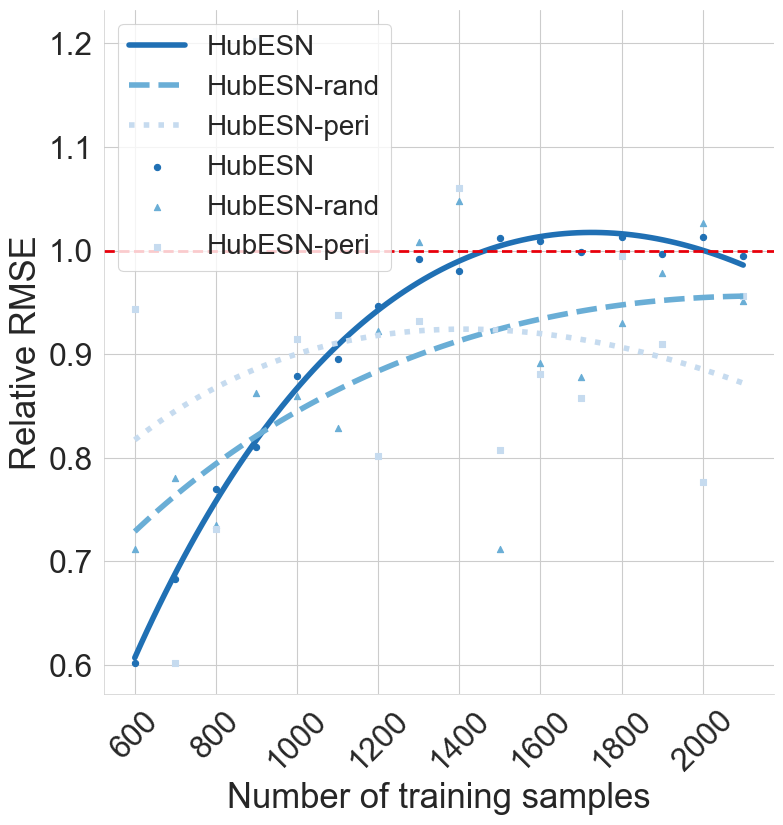

In [87]:
from scipy.optimize import curve_fit

cur_task = 'narma10'
n_trains = get_plot_range(cur_task)
esn_mean, esn_std, hubesn_mean, hubesn_std = load_n_trains_results('hub', cur_task, n_trains, std_mode='std')
esn_rand_mean, esn_rand_std, hubesn_rand_mean, hubesn_rand_std = load_n_trains_results('rand', cur_task, n_trains, std_mode='std')
esn_peri_mean, esn_peri_std, hubesn_peri_mean, hubesn_peri_std = load_n_trains_results('peri', cur_task, n_trains, std_mode='std')

# plot settings
font_scale = 2.6
plot_error = False
font_size = 20
capsize = 3
lw = 4
size = 20
hub_color = 2
rand_color = 1
peri_color = 0
plot_tasks = [0, 1, 2]
plot_curv = True

# begin plotting
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=font_scale)
sns.set_color_codes("bright")
colors = sns.color_palette("Blues", 3)
fig, ax = plt.subplots(figsize=(8, 8))


# fit a parabola to hub_ratio
def parabola(x, a, b, c, d):
    return a*x**d + b*x + c

x = np.linspace(n_trains.min(), n_trains.max(), 100)
hub_ratio = hubesn_mean/esn_mean
rand_ratio = hubesn_rand_mean/esn_mean
peri_ratio = hubesn_peri_mean/esn_mean
if plot_curv:
    if 0 in plot_tasks:
        print('hub')
        print(esn_mean)
        print(hub_ratio)
        print(hubesn_mean)
        hub_popt, _ = curve_fit(parabola, n_trains, hub_ratio)
        ax.plot(x, parabola(x, *hub_popt), color=colors[hub_color], label='HubESN', lw=lw, ls='-')
    if 1 in plot_tasks:
        print('rand')
        print(esn_mean)
        print(rand_ratio)
        print(hubesn_rand_mean)
        rand_popt, _ = curve_fit(parabola, n_trains, rand_ratio)
        ax.plot(x, parabola(x, *rand_popt), color=colors[rand_color], label='HubESN-rand', lw=lw, ls='--')
    if 2 in plot_tasks:
        print('peri')
        print(esn_mean)
        print(peri_ratio)
        print(hubesn_peri_mean)
        peri_popt, _ = curve_fit(parabola, n_trains, peri_ratio)
        ax.plot(x, parabola(x, *peri_popt), color=colors[peri_color], label='HubESN-peri', lw=lw, ls=':')

if 0 in plot_tasks:
    ax.scatter(n_trains, hub_ratio, color=colors[hub_color], label='HubESN', s=size, marker='o')
if 1 in plot_tasks:
    ax.scatter(n_trains, rand_ratio, color=colors[rand_color], label='HubESN-rand', s=size, marker='^')
if 2 in plot_tasks:
    ax.scatter(n_trains, peri_ratio, color=colors[peri_color], label='HubESN-peri', s=size, marker='s')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# add a horizontal line at y = 1
ax.axhline(y=1, color='r', linestyle='--', lw=2)
plt.legend(prop={'size': font_size})
plt.tight_layout()
plt.xticks(np.arange(n_trains.min(), n_trains.max()+1, 200), rotation=45)
plt.xlabel('Number of training samples')
plt.ylabel('Relative RMSE')
plt.savefig(f'{PLTPATH}/ntrain_relative_rmse.jpg', dpi=300, bbox_inches='tight')

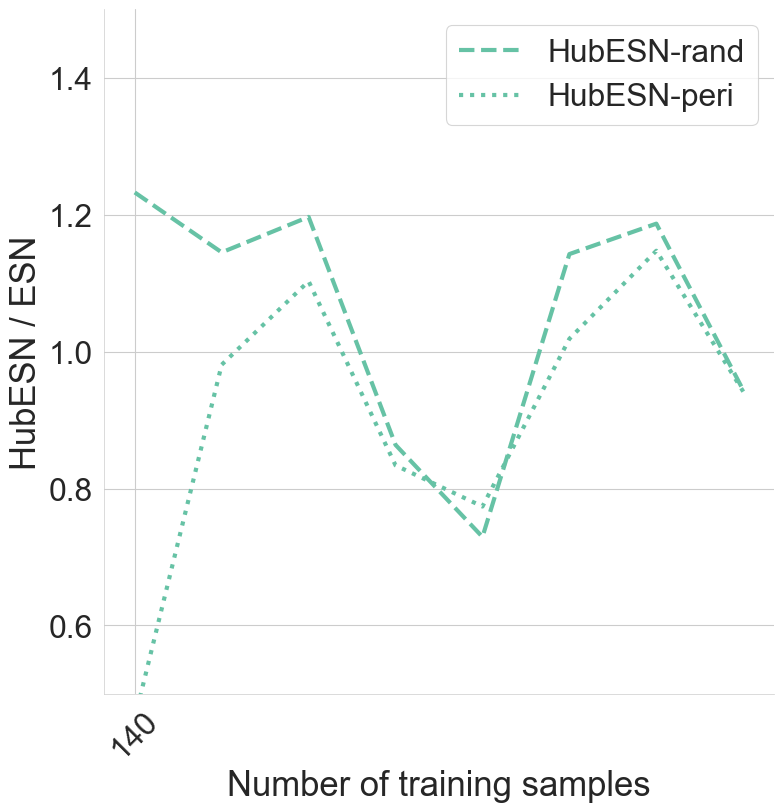

In [33]:
# plot settings
lw = 3
font_scale = 2.6
plot_error = False
font_size = 20
capsize = 3
size = 80
esn_color = 2
hubesn_color = 0
lw_inset = 1.5

# begin plotting
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=font_scale)
sns.set_color_codes("bright")
colors = sns.color_palette("Set2")
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(n_trains, esn_rand_mean/esn_mean, color=colors[hubesn_color], label='HubESN-rand', lw=lw, ls='--')
ax.plot(n_trains, esn_peri_mean/esn_mean, color=colors[hubesn_color], label='HubESN-peri', lw=lw, ls=':')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
plt.ylim([0.5, 1.5])
plt.tight_layout()
plt.legend()
plt.xticks(np.arange(n_trains.min(), n_trains.max()+1, 200), rotation=45)
plt.xlabel('Number of training samples')
plt.ylabel('HubESN / ESN')
plt.savefig(f'{PLTPATH}/ntrain_relative_rmse.jpg', dpi=300, bbox_inches='tight')